In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from shapely import wkt
import json
import rasterio
import os
from rasterio.mask import mask
import numpy as np
from datetime import date, timedelta
from shapely.plotting import patch_from_polygon

In [2]:
def day_number_to_date(day_number, year=2024):
    day_number = int(day_number)  # Ensure day_number is an integer
    start_date = date(year, 1, 1)
    target_date = start_date + timedelta(days=day_number - 1)
    return target_date.strftime("%Y-%m-%d")  # Convert to string and return

In [3]:
#read county_graph.gml and get some basic information
G = nx.read_gml('county_graph.gml')
for node in G.nodes():
    G.nodes[node]['geometry'] = wkt.loads(G.nodes[node]['geometry'])

In [4]:

first_node = list(G.nodes(data=True))[0]
print(first_node)
#print name of first node
print(first_node[0])

('Georgia_Appling', {'state': 'Georgia', 'county': 'Appling', 'geometry': <MULTIPOLYGON (((-82.227 31.531, -82.228 31.532, -82.228 31.533, -82.229 31....>})
Georgia_Appling


In [5]:
northernmost = max(G.nodes[node]['geometry'].bounds[3] for node in G.nodes())
southernmost = min(G.nodes[node]['geometry'].bounds[1] for node in G.nodes())
easternmost = max(G.nodes[node]['geometry'].bounds[2] for node in G.nodes())
westernmost = min(G.nodes[node]['geometry'].bounds[0] for node in G.nodes())

print(southernmost, westernmost, northernmost, easternmost)

30.357130051000127 -85.60550689799993 35.21611022899998 -78.54666900599995


In [6]:
#read the ntl data
ntl_tiles = {}
path = '../ntl_long_range/'

for file in sorted(os.listdir(path)):
    if file.endswith('.tif'):
        if int(file[9:13])==2023:
            date_value = day_number_to_date(int(file[13:16]), year=2023)
        else:
            date_value = day_number_to_date(int(file[13:16]))
        ntl_tiles[date_value] = rasterio.open(path + file)

In [7]:
#get earliest and latest dates
earliest_date = min(ntl_tiles.keys())
latest_date = max(ntl_tiles.keys())
print("Range of dates", earliest_date, latest_date)

Range of dates 2023-09-01 2024-11-17


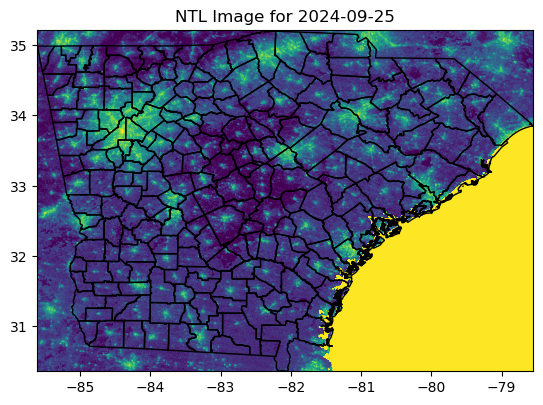

No data available for 2024-09-26


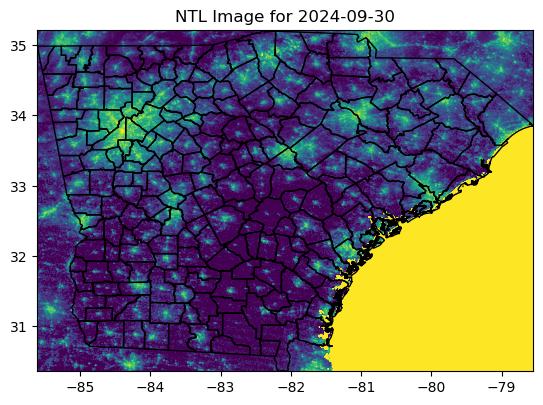

In [8]:
#plot the ntl image for a given date
def plot_ntl_image(date_str, show_counties=False):
    if date_str in ntl_tiles:
        tile_example = ntl_tiles[date_str]
        max_val = sorted(tile_example.read(1).flatten())[-2]

        fig, ax = plt.subplots()
        plt.imshow(tile_example.read(1), cmap='viridis', norm="log", vmax=2000, extent=[tile_example.bounds.left, tile_example.bounds.right, tile_example.bounds.bottom, tile_example.bounds.top])
        if show_counties:
            for node in G.nodes():
                polygon = G.nodes[node]['geometry']
                patch = patch_from_polygon(polygon, edgecolor='black', facecolor='none')
                ax.add_patch(patch)
            ax.set_xlim(westernmost, easternmost)
            ax.set_ylim(southernmost, northernmost)
        
        plt.title(f"NTL Image for {date_str}")
        plt.show()
        plt.close(fig)
    else:
        print(f"No data available for {date_str}")


plot_ntl_image("2024-09-25", show_counties=True)
plot_ntl_image("2024-09-26", show_counties=True)
plot_ntl_image("2024-09-30", show_counties=True)


In [9]:
#compute ntl measurements. This might take some time
for node in G.nodes():
    geometry = G.nodes[node]['geometry']
    ntl_values_dict = {}

    for tile_date, tile in ntl_tiles.items():
        crop_img, crop_transform = mask(tile, shapes=[geometry], crop=True, all_touched=True)
        crop_img[crop_img == 65535] = 0  # set filler value to 0

        flattened_img = crop_img[0].flatten()
        sum_ntl = flattened_img.sum()
        avg_ntl = flattened_img.mean()

        ntl_values_dict[tile_date] = {f"{tile_date}_sum": float(sum_ntl), f"{tile_date}_avg": float(avg_ntl)}

    G.nodes[node]['ntl'] = ntl_values_dict

The following plot does have a jump in time from 2023 to 2024.

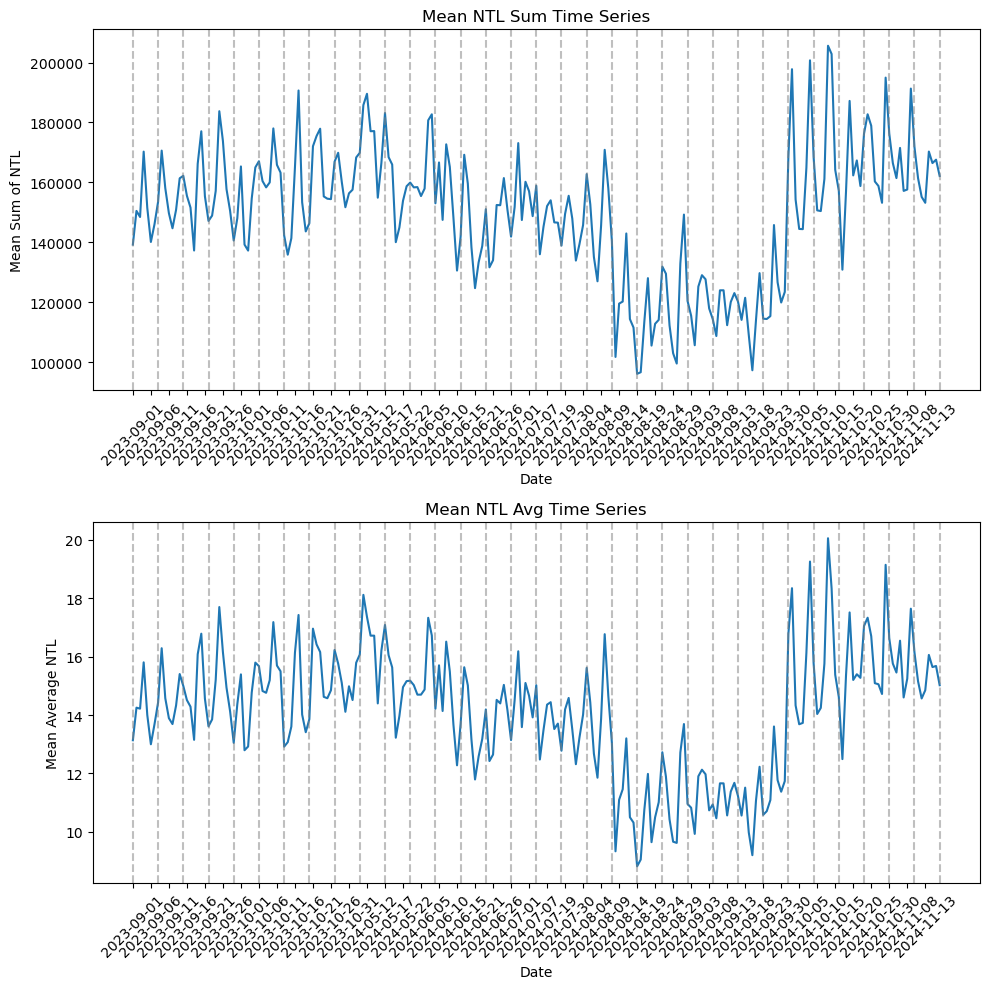

In [10]:
# Initialize dictionaries to store sum and average NTL values for each date
mean_ntl_sum = {}
mean_ntl_avg = {}

# Iterate over all nodes and accumulate NTL values
for node in G.nodes():
    for date, ntl_values in G.nodes[node]['ntl'].items():
        if date not in mean_ntl_sum:
            mean_ntl_sum[date] = []
            mean_ntl_avg[date] = []
        mean_ntl_sum[date].append(ntl_values[f"{date}_sum"])
        mean_ntl_avg[date].append(ntl_values[f"{date}_avg"])

# Calculate mean values for each date
mean_ntl_sum = {date: np.mean(values) for date, values in mean_ntl_sum.items()}
mean_ntl_avg = {date: np.mean(values) for date, values in mean_ntl_avg.items()}

# Plot the mean NTL values over all nodes for all days
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(list(mean_ntl_sum.keys()), list(mean_ntl_sum.values()))
ax[0].set_title("Mean NTL Sum Time Series")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Mean Sum of NTL")
# plot x axis only every 10 days and rotate the labels
ax[0].set_xticks(list(mean_ntl_sum.keys())[::5])
ax[0].tick_params(axis='x', rotation=45)
#add vertical line every 7 days
for i in range(0, len(list(mean_ntl_sum.keys())), 7):
    ax[0].axvline(x=list(mean_ntl_sum.keys())[i], color='gray', linestyle='--', alpha=0.5)

ax[1].plot(list(mean_ntl_avg.keys()), list(mean_ntl_avg.values()))
ax[1].set_title("Mean NTL Avg Time Series")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Mean Average NTL")
# plot x axis only every 10 days
ax[1].set_xticks(list(mean_ntl_avg.keys())[::5])
ax[1].tick_params(axis='x', rotation=45)
#add vertical line every 7 days

for i in range(0, len(list(mean_ntl_avg.keys())), 7):
    ax[1].axvline(x=list(mean_ntl_avg.keys())[i], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
# Convert the 'ntl' dictionary to a JSON string for each node
for node, data in G.nodes(data=True):
    if 'ntl' in data:
        data['ntl'] = json.dumps(data['ntl'])

for node, data in G.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = data['geometry'].wkt  # Convert to WKT string

nx.write_gml(G, "county_graph_with_ntl.gml")

In [12]:
'''
# Read the GML file
G = nx.read_gml("county_graph_with_ntl.gml")

# Convert the 'geometry' from WKT string back to Shapely geometry and 'ntl' from JSON string back to dictionary
for node, data in G.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = wkt.loads(data['geometry'])
    if 'ntl' in data:
        data['ntl'] = json.loads(data['ntl'])

# Verify the conversion
first_node = list(G.nodes(data=True))[0]
print(first_node)
'''

'\n# Read the GML file\nG = nx.read_gml("county_graph_with_ntl.gml")\n\n# Convert the \'geometry\' from WKT string back to Shapely geometry and \'ntl\' from JSON string back to dictionary\nfor node, data in G.nodes(data=True):\n    if \'geometry\' in data:\n        data[\'geometry\'] = wkt.loads(data[\'geometry\'])\n    if \'ntl\' in data:\n        data[\'ntl\'] = json.loads(data[\'ntl\'])\n\n# Verify the conversion\nfirst_node = list(G.nodes(data=True))[0]\nprint(first_node)\n'